In [ ]:
# Purpose of this model: Reduce the dimensions of MNIST dataset
# Data for the model:
# - 70000 handwritten black-and-white images
# -- 60000 training images
# -- 10000 validation images
# -- images contain numbers 0, 1, 2, 3, 4, 5, 6, 7, 8, and 9
# Models built in this notebook:
# - PCA
# - Autoencoder
# - Variational autoencoder

In [1]:
# Step 1: Import dependencies
import numpy as np
import matplotlib.pyplot as plt

# Importing the MNIST dataset
from tensorflow.keras.datasets import mnist

In [2]:
# Step 2: Loading the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Step 3: Determining the shape of Features of the training set
x_train.shape

(60000, 28, 28)

In [4]:
# Step 4: Preprocessing the dataset by scaling images pixels to be between 0 and 1
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [5]:
# Step 5: Flattening the data (i.e., 60000 training data of (28 * 28) 784 Features)
x_train_flat = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_test_flat = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))
print(x_train_flat.shape)
print(x_test_flat.shape)

(60000, 784)
(10000, 784)


In [6]:
# Step 6: Scaling the Features
from sklearn.preprocessing import MinMaxScaler
s = MinMaxScaler().fit(x_train_flat)
x_train_scaled = s.transform(x_train_flat)

In [ ]:
# Step 7: Setting up PCA
from sklearn.decomposition import PCA

def mnist_pca(x_data, n_components):
  pca = PCA(n_components = n_components)
  fit_pca = pca.fit(x_data)
  print("Variance explained with {0} components:".format(n_components),
        round(sum(fit_pca.explained_variance_ratio_), 2))

  return fit_pca, fit_pca.transform(x_data)

In [ ]:
# Step 8: Executing PCA
pca_full, mnist_data_full = mnist_pca(x_train_scaled, 784)

Variance explained with 784 components: 1.0


Text(0, 0.5, 'Proportion of variance explained')

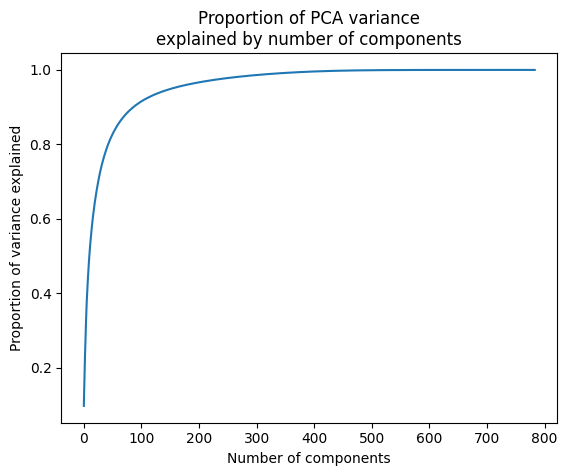

In [ ]:
# Step 9: Plotting the proportion of PCA variance explained against number of PCA components
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.title("Proportion of PCA variance\nexplained by number of components")
plt.xlabel("Number of components")
plt.ylabel("Proportion of variance explained")

In [ ]:
# Step 10: Executing PCA using 2 components
pca_2, mnist_data_2 = mnist_pca(x_train_scaled, 250)

Variance explained with 250 components: 0.98


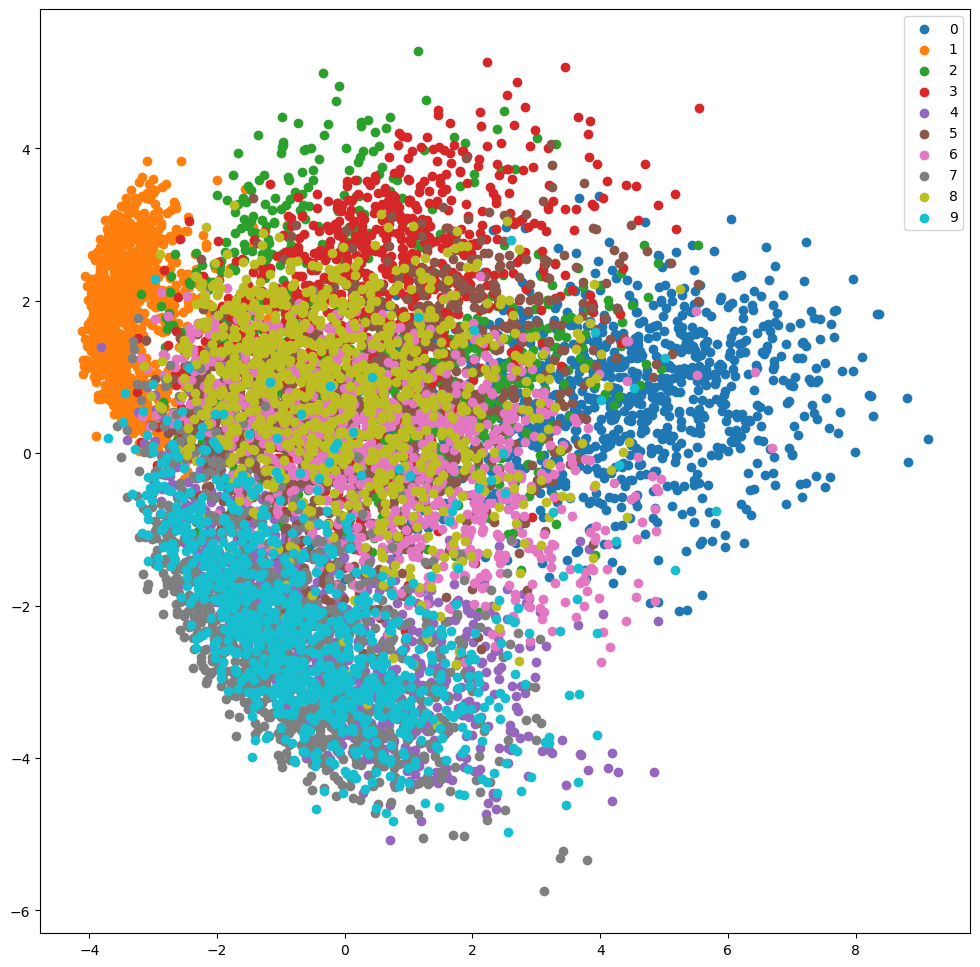

In [ ]:
# Step 11: Plotting PCA outcome
num_images_per_class = 1000
fig = plt.figure(figsize = (12,12))

for number in list(range(10)):
  mask = y_train == number
  x_data = mnist_data_2[mask, 0][:num_images_per_class]
  y_data = mnist_data_2[mask, 1][:num_images_per_class]
  plt.scatter(x_data, y_data, label=number, alpha=1)

plt.legend()

In [ ]:
# Step 12: Evaluating the performance of PCA using MSE

# Scaling Features of test set
x_test_scaled = s.transform(x_test_flat)

# Transform the scaled Features of test set using PCA
x_test_flat_pca = pca_2.transform(x_test_scaled)

# Reconstruct data
x_test_reconstructed_pca = pca_2.inverse_transform(x_test_flat_pca)

# Determining shape of reconstructed data
print("- Shape of reconstructed Features data:", x_test_reconstructed_pca.shape)

# Establishing the true and reconstructed data for MSE calculation
true = x_test_scaled
reconstructed = x_test_reconstructed_pca

# Defining a function for MSE calculation
def mse_reconstruction(true, reconstructed):
  mse_val = np.sum(np.power(true - reconstructed, 2)/true.shape[1])
  return mse_val



- Shape of reconstructed Features data: (10000, 784)


In [ ]:
# Step 13: Importing keras models and layers for building autoencoder
# Importing model for autoencoder from keras
from tensorflow.keras.models import Model

# IImporting layers for autoencoder from keras
from tensorflow.keras.layers import Input, Dense

In [ ]:
# Step 14: Build an autoencoder
ENCODING_DIM = 64
HIDDEN_DIM = 256

# Building the encoder model
inputs = Input(shape=(x_train_flat.shape[1],))
encoder_hidden = Dense(HIDDEN_DIM, activation = 'relu')(inputs) ## Hidden Dense layer for encoder
encoded = Dense(ENCODING_DIM, activation="sigmoid")(encoder_hidden)
encoder_model = Model(inputs, encoded, name='encoder')

# Building the decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
decoder_hidden = Dense(HIDDEN_DIM, activation='relu')(encoded_inputs) ## Hidden Dense layer for decoder
reconstruction = Dense(x_train_flat.shape[1], activation = "sigmoid")(decoder_hidden)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Building the full autoencoder model
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name = 'full_autoencoder')

# Specifying the inputs and outputs for the full model
full_model = Model(inputs = inputs,
                   outputs = outputs)

# Compiling the full model
full_model.compile(optimizer = 'rmsprop',
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

# Creating summmary of the full model
full_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 64)                  │         217,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 784)                 │         218,128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 435,536 (1.66 MB)

 Trainable params: 435,536 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 15: Training the autoencoder model
# Inputs and outputs are x_train_flat
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=5, batch_size=32)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.0110 - loss: 0.2695
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.0083 - loss: 0.1760
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.0120 - loss: 0.1482
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.0092 - loss: 0.1303
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0113 - loss: 0.1193


In [ ]:
# Step 16: Making a prediction for the test set using the encoder model
encoded_images = encoder_model.predict(x_test_flat)
encoded_images.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(10000, 64)

In [ ]:
encoded_images[0]

array([0.94721466, 0.9846536 , 0.575987  , 0.07712908, 0.9868407 ,
       0.3931178 , 0.97766113, 0.9323431 , 0.5267451 , 0.26983485,
       0.03184171, 0.94165736, 0.8718752 , 0.16868109, 0.26269335,
       0.64850724, 0.69401187, 0.11453834, 0.21997732, 0.4492931 ,
       0.91529775, 0.43436638, 0.9886017 , 0.78163743, 0.9530232 ,
       0.4098439 , 0.9478682 , 0.27488893, 0.22349563, 0.68283147,
       0.43281114, 0.32410052, 0.96313393, 0.4406543 , 0.9828063 ,
       0.17337422, 0.9865554 , 0.9783864 , 0.98949564, 0.1865886 ,
       0.85772157, 0.76470906, 0.84437484, 0.48838255, 0.49800318,
       0.5399012 , 0.02998658, 0.5304606 , 0.6925949 , 0.5938462 ,
       0.953059  , 0.89991236, 0.26092377, 0.93573666, 0.689664  ,
       0.9165151 , 0.9767646 , 0.98102415, 0.24860694, 0.86369413,
       0.9915161 , 0.09736166, 0.13742737, 0.8631126 ], dtype=float32)

In [ ]:
# Step 17: Evaluating the performance of the autoencoder
decoded_images = full_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


160.69124

In [ ]:
# Step 18: Defining function to collect all the steps for training the autoencoder
def train_autoencoder(num_epochs = 1):

  ENCODING_DIM = 64
  HIDDEN_DIM = 256

  # Building the encoder model
  inputs = Input(shape=(x_train_flat.shape[1],))
  encoder_hidden = Dense(HIDDEN_DIM, activation = 'relu')(inputs) ## Hidden Dense layer for encoder
  encoded = Dense(ENCODING_DIM, activation="sigmoid")(encoder_hidden)
  encoder_model = Model(inputs, encoded, name='encoder')

  # Building the decoder model
  encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
  decoder_hidden = Dense(HIDDEN_DIM, activation='relu')(encoded_inputs) ## Hidden Dense layer for decoder
  reconstruction = Dense(x_train_flat.shape[1], activation = "sigmoid")(decoder_hidden)
  decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

  # Building the full autoencoder model
  outputs = decoder_model(encoder_model(inputs))
  full_model = Model(inputs, outputs, name = 'full_autoencoder')

  # Specifying the inputs and outputs for the full model
  full_model = Model(inputs = inputs,
                   outputs = outputs)

  # Compiling the full model
  full_model.compile(optimizer = 'rmsprop',
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

  mse_res = []
  for i in range(num_epochs):

    history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=1, batch_size=32)
    decoded_images = full_model.predict(x_test_flat)
    reconstruction_loss = mse_reconstruction(decoded_images, x_test_flat)
    mse_res.append(reconstruction_loss)
    print("Reconstruction loss after epoch {0} is {1}".format(i+1, reconstruction_loss))

  return mse_res

In [ ]:
# Step 19: Executing the function for training the autoencoder model
loss_ae = train_autoencoder(10)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.0096 - loss: 0.2649
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Reconstruction loss after epoch 1 is 379.4979553222656
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0109 - loss: 0.1693
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Reconstruction loss after epoch 2 is 273.3780517578125
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0119 - loss: 0.1431
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Reconstruction loss after epoch 3 is 216.0845947265625
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0113 - loss: 0.1272
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Reconstruction loss after epoch 4 is 180.4500732421875
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.0113 - loss: 0.1181
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Reconstruction loss after epoch 5 is 160.18899536132812
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0106 - loss: 0.1119
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Reconstruc

In [ ]:
# Step 20: Plotting MSE versus epoch for autoencoder
plt.plot(range(10), loss_ae)
plt.xlabel("Epoch")
plt.ylabel(" Mean squared error (MSE)")

In [ ]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Normalize and reshape ============

#Norm.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

# Reshape
img_width  = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1 #MNIST --> grey scale so 1 channel
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)
# ========================
#View a few images
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[42][:,:,0])

plt.subplot(222)
plt.imshow(x_train[420][:,:,0])

plt.subplot(223)
plt.imshow(x_train[4200][:,:,0])

plt.subplot(224)
plt.imshow(x_train[42000][:,:,0])
plt.show()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 32)     │            320 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 2048)           │              0 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │          4,098 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │          4,098 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_2 (Sampling)     │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 235s 191ms/step - kl_loss: 2.8651 - reconstruction_loss: 117.5321 - total_loss: 120.3971 - val_kl_loss: 4.0099 - val_loss: 80.2701 - val_reconstruction_loss: 76.2603
Epoch 2/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 226s 188ms/step - kl_loss: 4.0966 - reconstruction_loss: 77.9929 - total_loss: 82.0895 - val_kl_loss: 4.4270 - val_loss: 77.5565 - val_reconstruction_loss: 73.1295
Epoch 3/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 235s 196ms/step - kl_loss: 4.5008 - reconstruction_loss: 74.9997 - total_loss: 79.5006 - val_kl_loss: 4.8218 - val_loss: 75.3237 - val_reconstruction_loss: 70.5020
Epoch 4/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 263s 197ms/step - kl_loss: 4.7257 - reconstruction_loss: 73.5264 - total_loss: 78.2521 - val_kl_loss: 4.7761 - val_loss: 75.7386 - val_reconstruction_loss: 70.9626
Epoch 5/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 259s 195ms/step - kl_loss: 4.8846 - reconstruction_loss: 72.4950 - total_loss: 77.3796 - val_kl_loss: 5.2037 - val_loss: 75.7870 - val_re

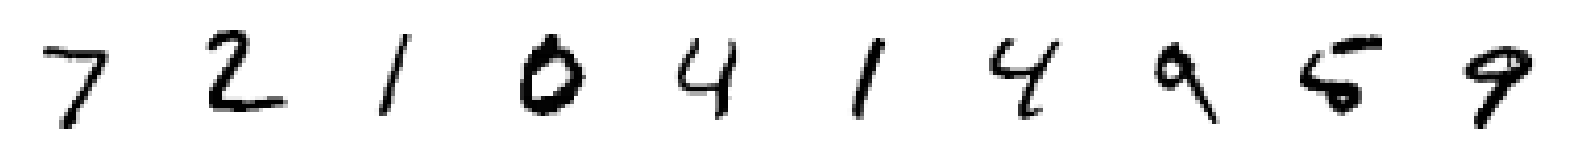

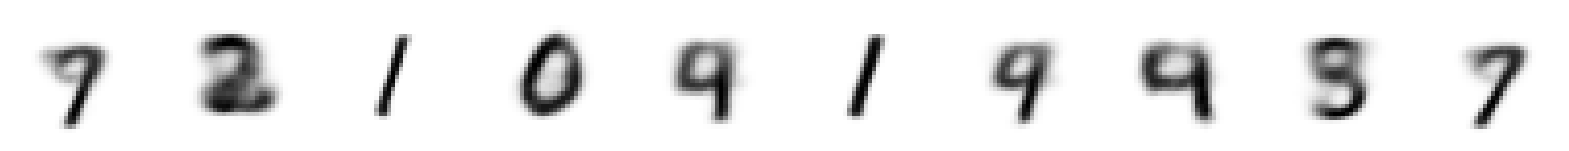

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


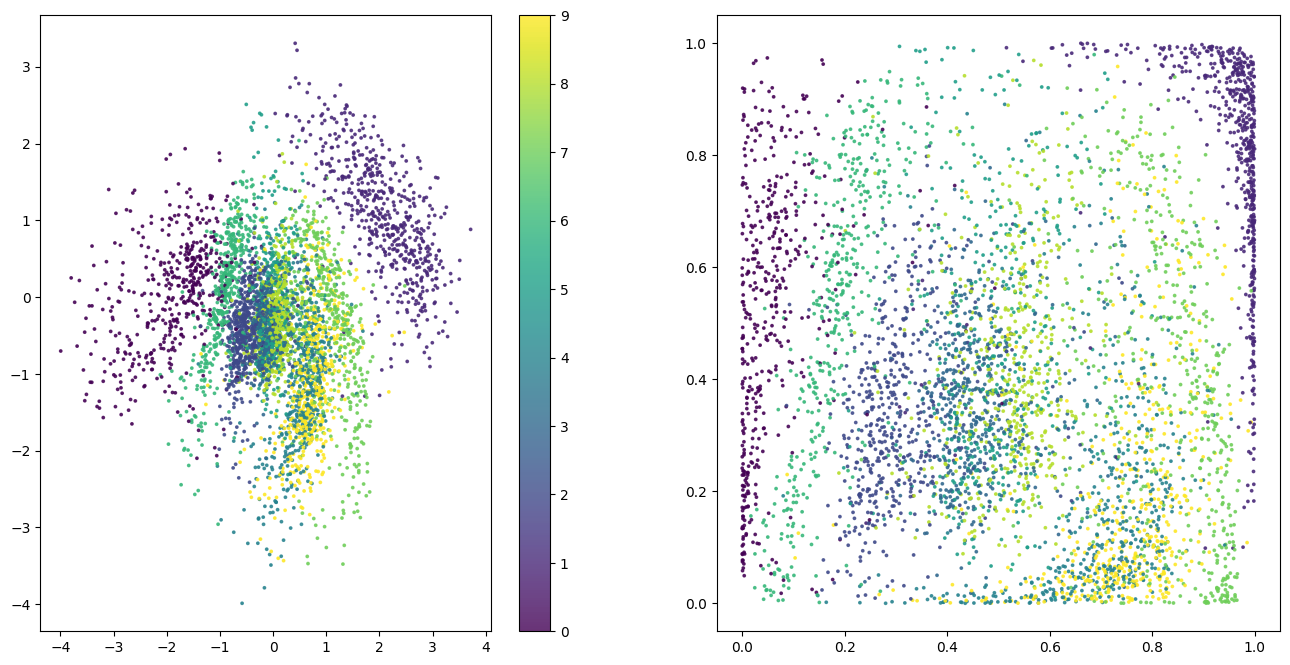

In [10]:
"""
VAEs can be used for generative purposes.

This code demonstrates VAE using MNIST dataset.
Just like regular autoencoder VAE returns an array (image) of same domensions
as input but we can introduce variation by tweaking the latent vector.

"""

# Importing dependencies
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from tensorflow.keras.datasets import mnist

# Sampling
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

# Load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the input images
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

# BUILD THE MODEL
# Defining a sampling layer
class Sampling(layers.Layer):

    #We create a new layer by subclassing the keras base Layer
    def call(self, inputs):

        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


# Building the encoder
image_size = 32
embed_dim = 2
encoder_input = layers.Input(
    shape=(image_size, image_size, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)

# Connecting the Flatten layer to layers z_mean and z_log_var
z_mean = layers.Dense(embed_dim, name="z_mean")(x)
z_log_var = layers.Dense(embed_dim, name="z_log_var")(x)

# The Sampling layer samples a point z in the latent space from the
#normal distribution defined by the parameters z_mean and z_log_var.
z = Sampling()([z_mean, z_log_var])

# The Keras Model that defines the encoder — a model that takes an input
# image and outputs z_mean, z_log_var and a sampled point z from the
# normal distribution defined by these parameters.
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


# Building the decoder
decoder_input = layers.Input(shape=(embed_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

# Assembling the model
class VAE(models.Model):

    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):

        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:

            #TensorFlow's Gradient Tape helps calculate gradients during a forward pass.
            #To use it, we need wrap the code that performs the operations you want to differentiate within a tf.GradientTape() context.
            #After recording the operations, we can compute the gradient of the loss function concerning certain variables using tape.gradient().
            #These gradients are then used to update the variables with the optimizer.

            z_mean, z_log_var, reconstruction = self(data)
            beta = 500
            reconstruction_loss = tf.reduce_mean(
                beta
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):

        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        beta = 500
        reconstruction_loss = tf.reduce_mean(
            beta
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Executing the class
vae = VAE(encoder, decoder)

# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

# Train the VAE
vae.fit(
    x_train,
    epochs=5,
    batch_size=50,
    shuffle=True,
    validation_data=(x_test, x_test)
)

# Reconstructing the input data
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)

# Display example images from input data and reconstructed data
display(example_images)
display(reconstructions)

# Visualizing the latent space
z_mean, z_var, z = encoder.predict(example_images)
p = norm.cdf(z)

figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)

# Plot of p-value
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], c=example_labels, alpha=0.8, s=3
)
plt.show()